In [1]:
import os
import sys

sys.path.append("..")

from scripts.core.text import remove_punctuation

from scripts.data_loaders.common import show_sample
from scripts.data_loaders.L1ARCTIC import L1ArcticDataset

from scripts.asr.whisper import whisper_transcribe_from_array
from scripts.asr.azure_speech import azure_transcribe_from_array
from scripts.asr.google_speech import google_transcribe_from_array
from scripts.asr.salad import salad_transcribe_from_array
from scripts.asr.owsm import owsm_transcribe_from_array

from scripts.eval.metrics import wer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import clear_output

clear_output()

In [12]:
l1_arctic = L1ArcticDataset(
    data_dir="../.data/CMU_ARCTIC", include_text=True, include_speaker_info=True
)

Loaded 15583 samples from 18 speakers


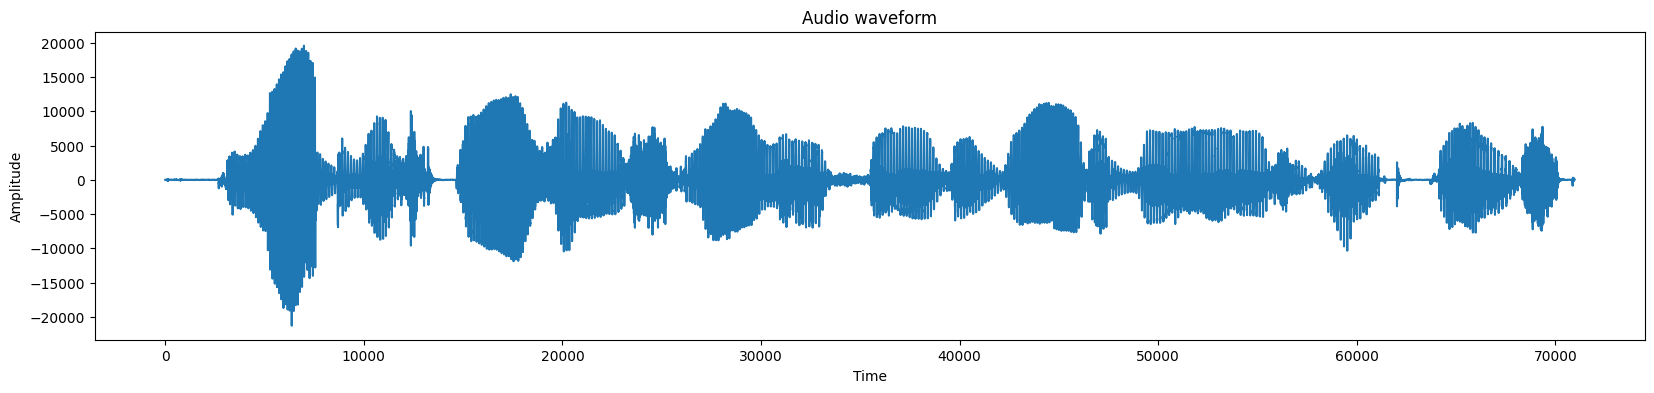

duration of audio:  4.4350625  seconds
text:  blood was oozing slowly from the wounded mans right breast


In [14]:
audio, text, speaker_info = l1_arctic[0]

# visualize the audio
plt.figure(figsize=(20, 4))
plt.plot(audio)
plt.title("Audio waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

print("duration of audio: ", len(audio) / 16000, " seconds")
# visualize the text
print("text: ", text)

# listen to audio
import IPython.display as ipd

ipd.Audio(audio, rate=16000)

In [17]:
print(l1_arctic[0][1])

blood was oozing slowly from the wounded mans right breast


In [18]:
predicted = owsm_transcribe_from_array(l1_arctic[0][0])
predicted = remove_punctuation(predicted).lower()
print(f"Predicted: {predicted}")
print(f"Reference: {l1_arctic[0][1]}")
error = wer(remove_punctuation(predicted), l1_arctic[0][1])
print(f"Error: {error}")

/Users/arunasrivastava/Koel/ML-eval/ML/venv/lib/python3.8/site-packages/espnet2/s2t/espnet_model.py:279: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(False):


Predicted: Blood was oozing slowly from the wounded man's right breast.
Reference: blood was oozing slowly from the wounded mans right breast
Error: 0.1


In [6]:
segments, info = whisper_transcribe_from_array(l1_arctic[0][0])
predicted = " ".join([segment.text for segment in segments])
predicted = remove_punctuation(predicted).lower()
print(f"Predicted: {predicted}")
print(f"Reference: {l1_arctic[0][1]}")
error = wer(predicted, l1_arctic[0][1])
print(f"Error: {error}")

Predicted:  Blood was oozing slowly from the wounded man's right breast.
Reference: blood was oozing slowly from the wounded mans right breast
Error: 0.3


In [7]:
predicted = " ".join(
    result.alternatives[0].transcript
    for result in google_transcribe_from_array(l1_arctic[3][0]).results
)
predicted = remove_punctuation(predicted).lower()
print(f"Predicted: {predicted}")
print(f"Reference: {l1_arctic[3][1]}")
error = wer(predicted, l1_arctic[3][1])
print(f"Error: {error}")

Predicted: since then some mysterious Force has been fighting us at every step
Reference: since then some mysterious force has been fighting us at every step
Error: 0.08333333333333333


In [8]:
predicted = azure_transcribe_from_array(l1_arctic[0][0])
predicted = " ".join(predicted)
predicted = remove_punctuation(predicted).lower()
print(f"Predicted: {predicted}")
print(f"Reference: {l1_arctic[0][1]}")
error = wer(predicted, l1_arctic[0][1])
print(f"Error: {error}")

Info: on_underlying_io_bytes_received: Close frame received
Info: on_underlying_io_bytes_received: closing underlying io.
Info: on_underlying_io_close_complete: uws_state: 6.
Predicted: Blood was oozing slowly from the wounded man's right breast.
Reference: blood was oozing slowly from the wounded mans right breast
Error: 0.1


In [9]:
predicted = salad_transcribe_from_array(l1_arctic[0][0])["text"]
clear_output()
print(f"Predicted: {predicted}")
print(f"Reference: {l1_arctic[0][1]}")
error = wer(predicted, l1_arctic[0][1])
print(f"Error: {error}")

Predicted:  Blood was oozing slowly from the wounded man's right breast.
Reference: blood was oozing slowly from the wounded mans right breast
Error: 0.3


In [20]:
RESULT_CSV = "../.data/asr_scores_l1_arctic.csv"
columns = [
    "native_language",
    "text_groundtruth",
    "text_whisper",
    "text_google",
    "text_azure",
    "text_salad",
    "text_owsm",
    "wer_whisper",
    "wer_google",
    "wer_azure",
    "wer_salad",
    "wer_owsm",
]

if os.path.exists(RESULT_CSV):
    results = pd.read_csv(RESULT_CSV)
    for col in columns:
        if col not in results.columns:
            results[col] = np.nan
    results = results[columns]
else:
    results = pd.DataFrame(columns=columns)

for i, sample in enumerate(l1_arctic):
    audio, text_groundtruth, speaker_info = sample
    native_language = speaker_info["accent"]

    if i < len(results) and not pd.isna(results["text_whisper"][i]):
        text_whisper = results["text_whisper"][i]
    else:
        try:
            segments, _ = whisper_transcribe_from_array(audio)
            text_whisper = " ".join(segment.text for segment in segments)
        except Exception as e:
            print(f"Whisper error {i}: {e}")
            text_whisper = None

    if i < len(results) and not pd.isna(results["text_azure"][i]):
        text_azure = results["text_azure"][i]
    else:
        try:
            text_azure = " ".join(azure_transcribe_from_array(audio))
        except Exception as e:
            print(f"Azure error {i}: {e}")
            text_azure = None

    if i < len(results) and not pd.isna(results["text_google"][i]):
        text_google = results["text_google"][i]
    else:
        try:
            text_google = " ".join(result.alternatives[0].transcript for result in google_transcribe_from_array(audio).results)  # type: ignore
        except Exception as e:
            print(f"Google error {i}: {e}")
            text_google = None

    if i < len(results) and not pd.isna(results["text_salad"][i]):
        text_salad = results["text_salad"][i]
    else:
        try:
            text_salad: "str | None" = salad_transcribe_from_array(audio)["text"]  # type: ignore
        except Exception as e:
            print(f"Salad error {i}: {e}")
            text_salad = None

    if i < len(results) and not pd.isna(results["text_owsm"][i]):
        text_owsm = results["text_owsm"][i]
    else:
        try:
            text_owsm: "str | None" = owsm_transcribe_from_array(audio)  # type: ignore
        except Exception as e:
            print(f"OWSM error {i}: {e}")
            text_owsm = None

    text_whisper = remove_punctuation(text_whisper.lower()) if text_whisper else None
    text_google = remove_punctuation(text_google.lower()) if text_google else None
    text_azure = remove_punctuation(text_azure.lower()) if text_azure else None
    text_salad = remove_punctuation(text_salad.lower()) if text_salad else None
    text_owsm = remove_punctuation(text_owsm.lower()) if text_owsm else None

    wer_whisper = wer(text_whisper, text_groundtruth) if text_whisper else None
    wer_google = wer(text_google, text_groundtruth) if text_google else None
    wer_azure = wer(text_azure, text_groundtruth) if text_azure else None
    wer_salad = wer(text_salad, text_groundtruth) if text_salad else None
    wer_owsm = wer(text_owsm, text_groundtruth) if text_owsm else None

    if i < len(results):
        results.at[i, "text_whisper"] = text_whisper
        results.at[i, "text_google"] = text_google
        results.at[i, "text_azure"] = text_azure
        results.at[i, "text_salad"] = text_salad
        results.at[i, "text_owsm"] = text_owsm
        results.at[i, "wer_whisper"] = wer_whisper
        results.at[i, "wer_google"] = wer_google
        results.at[i, "wer_azure"] = wer_azure
        results.at[i, "wer_salad"] = wer_salad
        results.at[i, "wer_owsm"] = wer_owsm
    else:
        results = pd.concat(
            [
                results,
                pd.DataFrame(
                    {
                        "native_language": [native_language],
                        "text_groundtruth": [text_groundtruth],
                        "text_whisper": [text_whisper],
                        "text_google": [text_google],
                        "text_azure": [text_azure],
                        "text_salad": [text_salad],
                        "text_owsm": [text_owsm],
                        "wer_whisper": [wer_whisper],
                        "wer_google": [wer_google],
                        "wer_azure": [wer_azure],
                        "wer_salad": [wer_salad],
                        "wer_owsm": [wer_owsm],
                    }
                ),
            ],
            ignore_index=True,
        )

    results.to_csv(RESULT_CSV, index=False)

Info: on_underlying_io_bytes_received: Close frame received
Info: on_underlying_io_bytes_received: closing underlying io.
Info: on_underlying_io_close_complete: uws_state: 6.
Status: uploading audio
Status: pending
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: running
Status: succeeded
{'url': 'https://storage-api.salad.com/organizations/salad/files/transcription/f430714e-8bf2-4cbb-b1db-9ccea758a021?token=89a824b0-cf40-4519-b41d-c522b13c9e34', 'duration_in_seconds': 5.285063, 'duration': 0.01, 'processing_time': 3.399190902709961}


/Users/arunasrivastava/Koel/ML-eval/ML/venv/lib/python3.8/site-packages/espnet2/s2t/espnet_model.py:279: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(False):


Info: on_underlying_io_bytes_received: Close frame received
Info: on_underlying_io_bytes_received: closing underlying io.
Info: on_underlying_io_close_complete: uws_state: 6.
Status: uploading audio
Status: pending
Status: running
Status: running
Status: succeeded
{'url': 'https://storage-api.salad.com/organizations/salad/files/transcription/3b987b82-fae7-4abc-82be-4cd482bcc348?token=702a2015-05e6-45dd-8d96-41a9a564c861', 'duration_in_seconds': 2.72, 'duration': 0.01, 'processing_time': 1.5867211818695068}
Info: on_underlying_io_bytes_received: Close frame received
Info: on_underlying_io_bytes_received: closing underlying io.
Info: on_underlying_io_close_complete: uws_state: 6.
Status: uploading audio
Status: pending
Status: running
Status: running
Status: running
Status: running
Status: running
Status: succeeded
{'url': 'https://storage-api.salad.com/organizations/salad/files/transcription/197d3a83-d2ae-479d-8339-45a5373bdf3e?token=1d1c3277-9b88-44ec-ad13-c3c63217232d', 'duration_in_s

In [10]:
# show rows where any of the wer are greater than 0.5
results[
    results[["wer_whisper", "wer_google", "wer_azure", "wer_salad", "wer_owsm"]]
    .gt(0.5)
    .any(axis=1)
].head(10)

,native_language,text_groundtruth,text_whisper,text_google,text_azure,text_salad,text_owsm,wer_whisper,wer_google,wer_azure,wer_salad,wer_owsm


In [5]:
# print the google output for line 13
print(results.iloc[13]["text_google"])
print(results.iloc[13]["text_groundtruth"])

so there is some big city with big buildings and a man and woman are walking past each other carrying identical luggage
so there is some big city with big buildings and a man and a woman are walking past each other carrying identical luggage and they hit each other fall down fall next to each other and take their own respective luggages and start walking they reach home only to realize that they actually took the other person's luggage the man starts seeing the woman's clothes in the suitcase and the woman starts seeing the man's clothes


IPA: soʊˈdɛˈɹɪssʌˈmbɪˈksɪˈtiwɪtbɪˈɡbʊˈlɪŋksæˈndʌmæˈnʌndwʊˈmʌnɑˈɹwɔˈkɪŋpæˈstiˈtʃʌˈðɝkɛˈɹiɪŋaɪdɛˈntɪkʌllʌˈɡɪdʒæˈndeɪˈhiˈtiˈtʃʌˈðɝfɔˈldɔˈnpɔˈləlɛˈstəiˈtʃʌˈðɝæˈnteɪˈdɛˈɹɔnɹɛspɛˈktuwlʌˈɡɪzʌsʌnstɑˈtwɔˈkɪŋðɛɹiˈtʃhuˈmɔnlituˈɹɪˈlaɪˌsdʌdææˈktlitʊˈθʌˈʌˈðəpəsʌnslʌˈɡɛtʃdʌmæˈnstɑˈɹtssiˈŋdʌʊˈmʌnskloʊˈθsɪndʌˈsuˈtkɛsɛndʌʊˈmʌnstɑˈtssiˈŋdʌmæˈnskloʊˈs
Metadata: {'gender': 'F', 'native-language': 'Hindi'} so there is some big city with big buildings and a man and a woman are walking past each other carrying identical luggage and they hit each other fall down fall next to each other and take their own respective luggages and start walking they reach home only to realize that they actually took the other person's luggage the man starts seeing the woman's clothes in the suitcase and the woman starts seeing the man's clothes


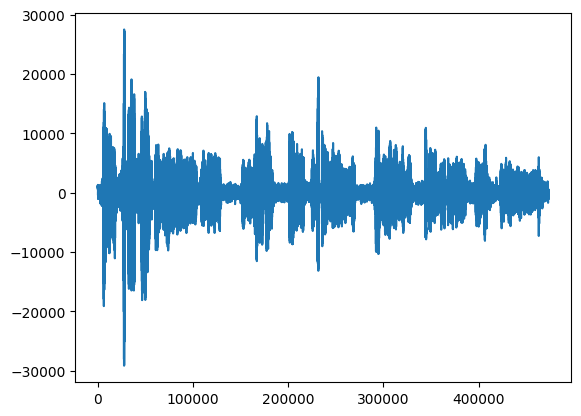

In [6]:
show_sample(suitcase[13])

In [8]:
# rerun the google transcribe on the audio
audio = suitcase[13][1]
segments = google_transcribe_from_array(audio, force_long_model=True)
predicted = " ".join(result.alternatives[0].transcript for result in segments.results)
print(f"Predicted: {predicted}")
print(f"Reference: {suitcase[13][3]}")
error = wer(suitcase[13][3], predicted)
print(f"Error: {error}")

Predicted: so there is some big city with big buildings and a man and woman or walking past each other carrying identical luggage  and they hit each other fall down  apologize to each other and take their own respective luggages and start walking  they reach home only to realize that they actually  took the other person's luggage the man starts seeing the woman's clothes in this suitcase and the woman starts seeing the man's clothes
Reference: so there is some big city with big buildings and a man and a woman are walking past each other carrying identical luggage and they hit each other fall down fall next to each other and take their own respective luggages and start walking they reach home only to realize that they actually took the other person's luggage the man starts seeing the woman's clothes in the suitcase and the woman starts seeing the man's clothes
Error: 0.06756756756756757


In [9]:
# this one only works with the long model for some reason, update the google result
results.at[13, "text_google"] = predicted
results.at[13, "wer_google"] = error
results.to_csv(RESULT_CSV, index=False)

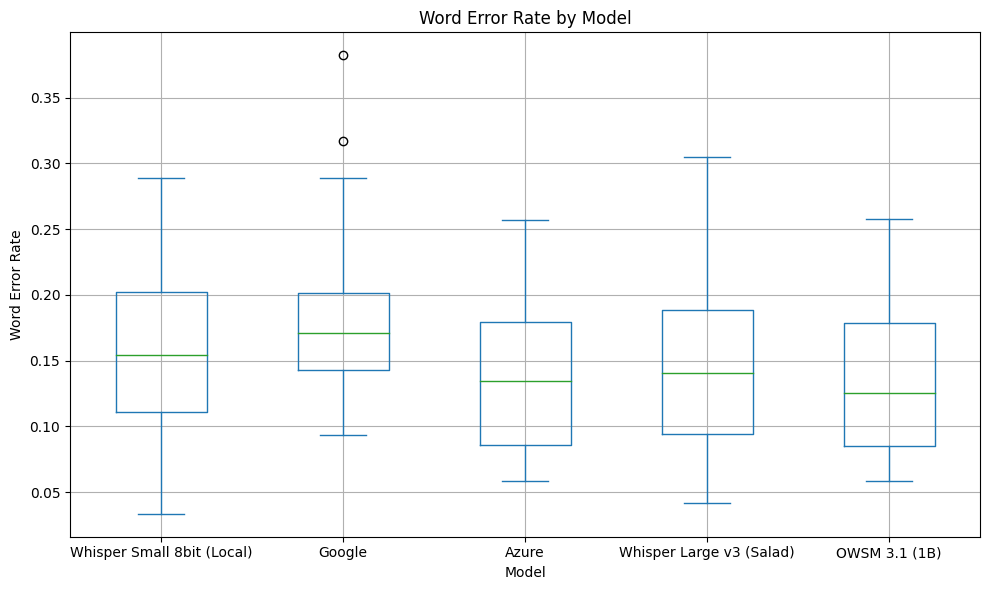

In [7]:
# plot wer by model
fig, ax = plt.subplots(figsize=(10, 6))
results[["wer_whisper", "wer_google", "wer_azure", "wer_salad", "wer_owsm"]].plot(
    kind="box", ax=ax
)
plt.xticks(
    [1, 2, 3, 4, 5],
    [
        "Whisper Small 8bit (Local)",
        "Google",
        "Azure",
        "Whisper Large v3 (Salad)",
        "OWSM 3.1 (1B)",
    ],
)
plt.title("Word Error Rate by Model")
plt.ylabel("Word Error Rate")
plt.xlabel("Model")
plt.grid()
plt.tight_layout()
plt.show()

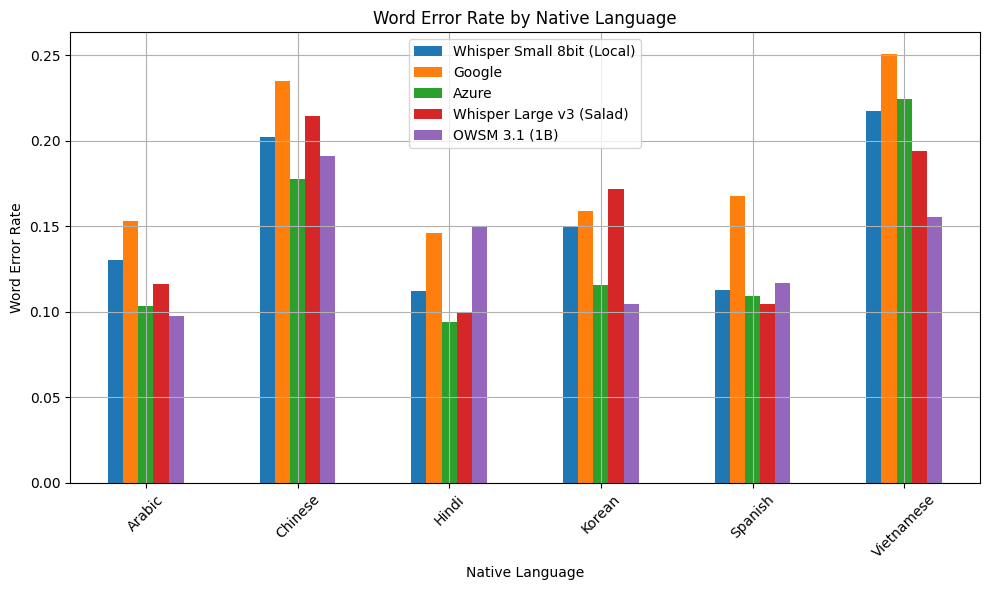

In [8]:
# plot wer by native language
fig, ax = plt.subplots(figsize=(10, 6))
grouped = results.groupby("native_language")[
    ["wer_whisper", "wer_google", "wer_azure", "wer_salad", "wer_owsm"]
].mean()
grouped.plot(kind="bar", ax=ax)
plt.xticks(rotation=45)
plt.legend(
    [
        "Whisper Small 8bit (Local)",
        "Google",
        "Azure",
        "Whisper Large v3 (Salad)",
        "OWSM 3.1 (1B)",
    ]
)
plt.title("Word Error Rate by Native Language")
plt.ylabel("Word Error Rate")
plt.xlabel("Native Language")
plt.grid()
plt.tight_layout()
plt.show()